<center>

# **Proyecto 4 : Predicción del número de vehículos registrados en el sistema de tránsito naciona**


**Integrantes:**

Hamza Lasri

Diego Zuluaga Castro

Juan Rafael Ramírez Builes

Carlos Daniel Sánchez Ramírez

</center>


In [54]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import plotly.express as px

In [55]:
# Importamos la biblioteca necesaria para montar Google Drive en Colab.
from google.colab import drive

# Montamos Google Drive en la carpeta '/content/drive' de Colab.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pretratamiento de datos

In [56]:
# Cargar el conjunto de datos desde un archivo Excel en la ruta especificada
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Trabajo 4/registros_autos_entrenamiento.xlsx')

In [57]:
# Verificar si hay valores nulos en el DataFrame
df.isnull().any()

Fecha       False
Unidades    False
dtype: bool

Utilizando el siguiente enlace, hemos creado un dataframe que lista todos los días festivos en Colombia desde 2012 hasta 2018: https://calendariohispanohablante.com/2012/calendario-colombia-2012.html.

In [58]:
# Leer datos de días festivos desde un archivo Excel
df_festivos = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Trabajo 4/dia_festivo.xlsx')

In [59]:
# Convertir la columna 'Date' en formato de fecha
df_festivos['Date'] = pd.to_datetime(df_festivos['Date'], format='%Y-%m-%d')

In [60]:
# Convertir la columna 'Fecha' a un objeto datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Extraer el día, mes, año y nombre del día en columnas separadas
df['Dia'] = df['Fecha'].dt.day
df['Mes'] = df['Fecha'].dt.month
df['Año'] = df['Fecha'].dt.year
df['Nombre_del_dia'] = df['Fecha'].dt.weekday + 1

In [61]:
# Crear un diccionario a partir de df_festivos para mapear los valores Holidays a df
holidays_mapping = dict(zip(df_festivos['Date'], df_festivos['Holiday']))

# Aplicar la correspondencia de vacaciones a df
df['Holiday'] = df['Fecha'].map(holidays_mapping).fillna(0).astype(int)

# Mostrar el DataFrame resultante
df

,Fecha,Unidades,Dia,Mes,Año,Nombre_del_dia,Holiday
0,2012-01-01,0,1,1,2012,7,1
1,2012-01-02,188,2,1,2012,1,0
2,2012-01-03,482,3,1,2012,2,0
3,2012-01-04,927,4,1,2012,3,0
4,2012-01-05,1159,5,1,2012,4,0
...,...,...,...,...,...,...,...
2187,2017-12-27,2102,27,12,2017,3,0
2188,2017-12-28,3449,28,12,2017,4,0
2189,2017-12-29,1084,29,12,2017,5,0
2190,2017-12-30,18,30,12,2017,6,0


# Analisis de Datos

In [62]:
# Agrupar por la columna 'Nombre_del_dia' y calcular la suma para la columna 'Unidades'
nombre_dia_analisis = df.groupby('Nombre_del_dia')['Unidades'].sum().reset_index()
nombre_dia_analisis

,Nombre_del_dia,Unidades
0,1,208582
1,2,314588
2,3,354427
3,4,361025
4,5,368495
5,6,106497
6,7,893


In [63]:
# Crear un gráfico de barras con Plotly Express
fig = px.bar(nombre_dia_analisis, x='Nombre_del_dia', y='Unidades', text='Unidades', title='Número de vehículos registrados por día de la semana')
# Estilo: color rosa para las barras
fig.update_traces(marker=dict(color='pink'))
# Mostrar el gráfico
fig.show()

Se produce un descenso importante en el número de matriculaciones de vehículos, especialmente los domingos y sábados.

In [64]:
# Agrupar por el año y calcular la suma para la columna 'Unidades'
año_analisis = df.groupby('Año')['Unidades'].sum().reset_index(name='Unidades')
año_analisis

,Año,Unidades
0,2012,311920
1,2013,295803
2,2014,327478
3,2015,284916
4,2016,254893
5,2017,239497


In [65]:
fig = px.bar(año_analisis, x='Año', y='Unidades', text='Unidades', title='Número de vehículos registrados por año')
fig.update_traces(marker=dict(color='red'))
fig.show()

Notamos un ligero descenso en el número de vehículos matriculados desde 2015

In [66]:
# Analizar el número total de vehículos registrados por mes.
mes_analisis = df.groupby('Mes')['Unidades'].sum().reset_index(name='Unidades')
mes_analisis

,Mes,Unidades
0,1,115653
1,2,132001
2,3,140967
3,4,136382
4,5,141168
5,6,133853
6,7,142714
7,8,144291
8,9,146002
9,10,146319


In [67]:
# Crear un gráfico de barras para analizar el número de vehículos registrados por mes.
fig = px.bar(mes_analisis, x='Mes', y='Unidades', text='Unidades', title='Número de vehículos registrados por mes')
fig.update_traces(marker=dict(color='green'))
fig.show()

Destaca que diciembre registra el mayor número de vehículos matriculados.


In [68]:
festivos_analisis = df.groupby('Holiday')['Unidades'].mean().reset_index(name='Unidades')
festivos_analisis

,Holiday,Unidades
0,0,822.150192
1,1,10.611111


In [69]:
fig = px.bar(festivos_analisis, x='Holiday', y='Unidades', text='Unidades', title='Número medio de vehículos matriculados en días festivos y excluidos días festivos')
fig.update_traces(marker=dict(color='violet'))
fig.show()

Se observa que el número de vehículos matriculados es considerablemente menor en los días festivos.

In [70]:
# Crear un gráfico de líneas que muestra los registros diarios de vehículos a lo largo del tiempo, con colores distintos para cada año.
fig = px.line(df, x='Fecha', y='Unidades', color='Año',
              title='Registros de vehículos diarios')

# Configurar el diseño del gráfico
fig.update_layout(xaxis_title='Año', yaxis_title='Número de vehículos')

# Mostrar el gráfico
fig.show()

Al igual que en el análisis mensual, observamos aquí un aumento significativo en el número de vehículos registrados en diciembre.

###División del Conjunto de Datos en Datos de Entrenamiento, Validación

In [71]:
# Filtrar los datos para obtener el conjunto de entrenamiento y validación
train_data = df[(df['Año'] >= 2012) & (df['Año'] <= 2016)]
validation_data = df[df['Año'] == 2017]

# Dividir los datos en características (X) y objetivo (y)
x_train = train_data.drop(columns={'Unidades', 'Fecha'}, axis=1)  # Suponiendo que 'Unidades' es la columna que deseas predecir
y_train = train_data['Unidades']

x_validation = validation_data.drop(columns={'Unidades', 'Fecha'}, axis=1)
y_validation = validation_data['Unidades']

# Mostrar las dimensiones de los conjuntos creados
print("Dimensiones del conjunto de entrenamiento (X_train, y_train):", x_train.shape, y_train.shape)
print("Dimensiones del conjunto de validación (X_validation, y_validation):", x_validation.shape, y_validation.shape)


Dimensiones del conjunto de entrenamiento (X_train, y_train): (1827, 5) (1827,)
Dimensiones del conjunto de validación (X_validation, y_validation): (365, 5) (365,)


# Modelo y resultados

Modelo: Regresión Lineal
Mean Squared Error (MSE): 178351.53474416895
Root Mean Squared Error (RMSE): 422.3168653323816
R2 Score: 0.36118366693022896



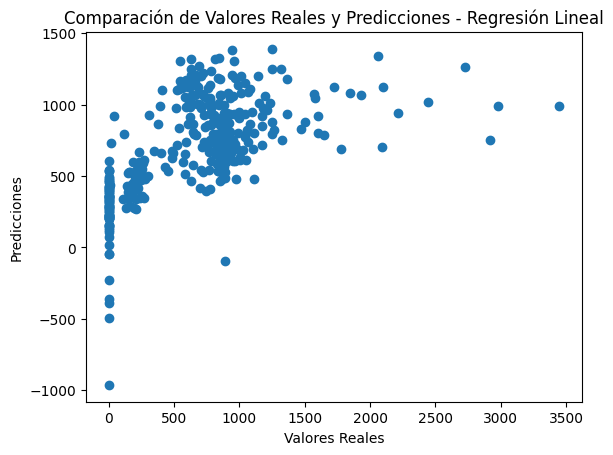

Modelo: Regresión Ridge
Mean Squared Error (MSE): 178133.6619269508
Root Mean Squared Error (RMSE): 422.0588370440202
R2 Score: 0.3619640398850821



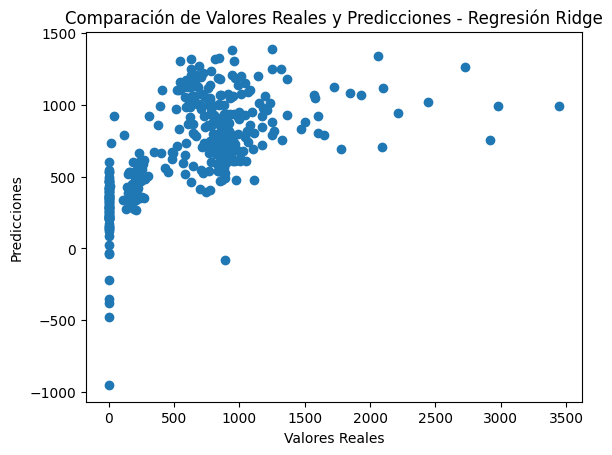

Modelo: Regresión Lasso
Mean Squared Error (MSE): 178087.68102119895
Root Mean Squared Error (RMSE): 422.0043613769874
R2 Score: 0.3621287334698372



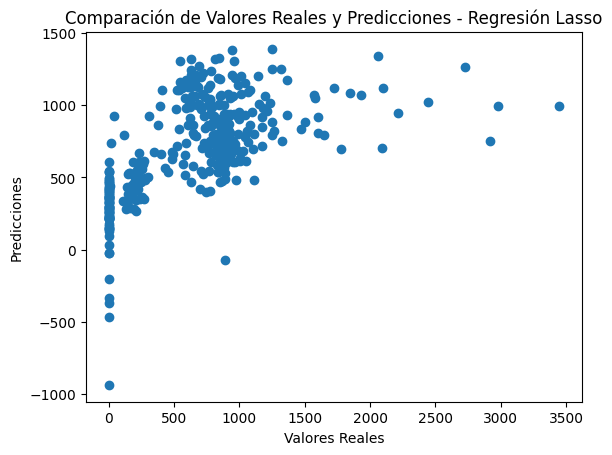

Modelo: Random Forest Regressor
Mean Squared Error (MSE): 35725.46699287672
Root Mean Squared Error (RMSE): 189.01181707204637
R2 Score: 0.8720391621281477



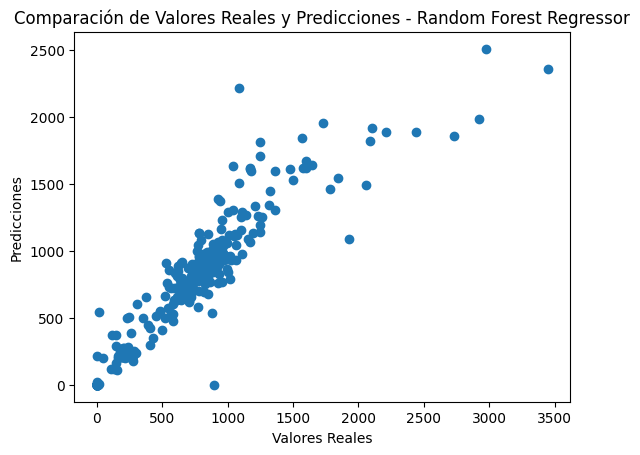

In [72]:
# Crear los modelos
models = {
    'Regresión Lineal': LinearRegression(),
    'Regresión Ridge': Ridge(),
    'Regresión Lasso': Lasso(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
}

# Entrenar y evaluar cada modelo
for model_name, model in models.items():
    model.fit(x_train, y_train)
    predictions = model.predict(x_validation)

    mse = mean_squared_error(y_validation, predictions)
    r2 = r2_score(y_validation, predictions)
    rmse = np.sqrt(mse)

    print(f'Modelo: {model_name}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'R2 Score: {r2}\n')

    # Mostrar las predicciones en comparación con los valores reales
    plt.scatter(y_validation, predictions)
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title(f'Comparación de Valores Reales y Predicciones - {model_name}')
    plt.show()


Modelo Final : Random Forest Regressor

Random Forest Regressor:
Mean Squared Error (MSE): 35725.46699287672
Root Mean Squared Error (RMSE): 189.01181707204637
R2 Score: 0.8720391621281477



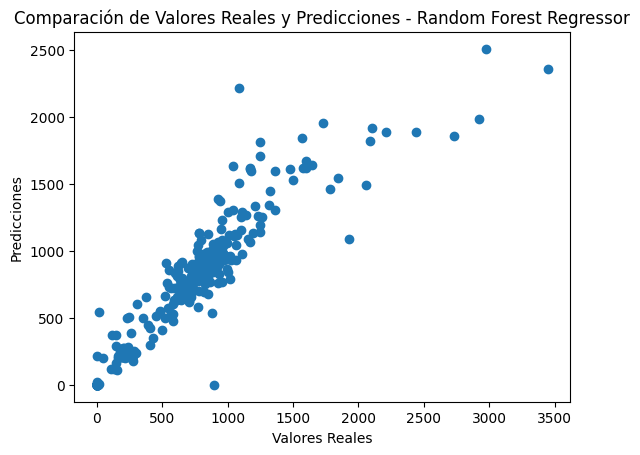

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Crear un modelo Random Forest Regressor
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo en el conjunto de entrenamiento
random_forest_model.fit(x_train, y_train)

# Realizar predicciones en el conjunto de validación
predictions_rf = random_forest_model.predict(x_validation)

# Evaluar el rendimiento del modelo
mse_rf = mean_squared_error(y_validation, predictions_rf)
r2_rf = r2_score(y_validation, predictions_rf)
rmse_rf = np.sqrt(mse_rf)

# Mostrar los resultados
print("Random Forest Regressor:")
print(f'Mean Squared Error (MSE): {mse_rf}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf}')
print(f'R2 Score: {r2_rf}\n')

# Mostrar las predicciones en comparación con los valores reales
plt.scatter(y_validation, predictions_rf)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Valores Reales y Predicciones - Random Forest Regressor')
plt.show()


Random Forest Regressor (Conjunto de Entrenamiento)
Mean Squared Error (MSE): 4070.4259391351943
Root Mean Squared Error (RMSE): 63.79988980503959
R2 Score: 0.9866422244357935



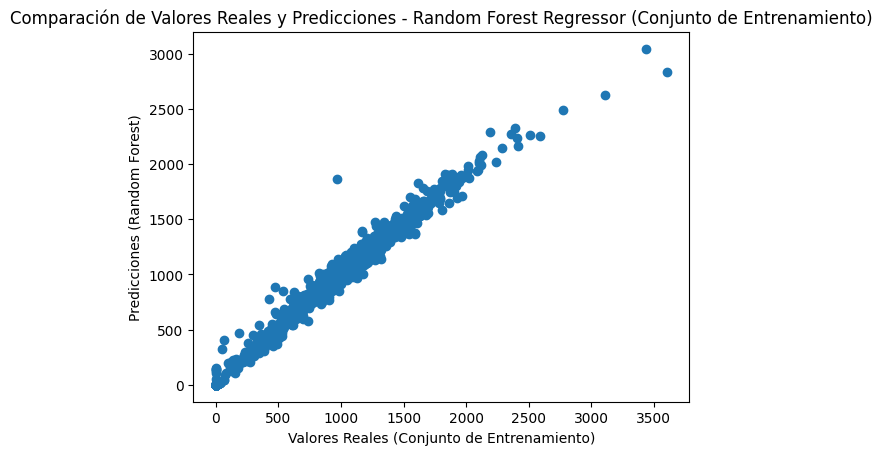

In [74]:
# Realizar predicciones en los datos de entrenamiento
rf_predictions_train = random_forest_model.predict(x_train)

# Evaluar el rendimiento del modelo en los datos de entrenamiento
mse_rf_train = mean_squared_error(y_train, rf_predictions_train)
rmse_rf_train = np.sqrt(mse_rf_train)
r2_rf_train = r2_score(y_train, rf_predictions_train)

print(f'Random Forest Regressor (Conjunto de Entrenamiento)')
print(f'Mean Squared Error (MSE): {mse_rf_train}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf_train}')
print(f'R2 Score: {r2_rf_train}\n')

# Mostrar las predicciones en comparación con los valores reales en el conjunto de entrenamiento
plt.scatter(y_train, rf_predictions_train)
plt.xlabel('Valores Reales (Conjunto de Entrenamiento)')
plt.ylabel('Predicciones (Random Forest)')
plt.title('Comparación de Valores Reales y Predicciones - Random Forest Regressor (Conjunto de Entrenamiento)')
plt.show()

# Predicción

Creación del dataframe del año 2018

In [75]:
# Crear una serie de fechas desde el 1 de enero de 2018 hasta el 30 de junio de 2018
date_range = pd.date_range(start='2018-01-01', end='2018-06-30', freq='D')

# Crear un DataFrame con la columna de fechas
df_dates = pd.DataFrame(date_range, columns=['Date'])

# Agregar las columnas adicionales
df_dates['Dia'] = df_dates['Date'].dt.day
df_dates['Mes'] = df_dates['Date'].dt.month
df_dates['Año'] = df_dates['Date'].dt.year
df_dates['Nombre_del_dia'] = df_dates['Date'].dt.weekday + 1

# Aplicar la correspondencia de días festivos a df
df_dates['Holiday'] = df_dates['Date'].map(holidays_mapping).fillna(0).astype(int)

# Mostrar el DataFrame resultante
df_dates

,Date,Dia,Mes,Año,Nombre_del_dia,Holiday
0,2018-01-01,1,1,2018,1,1
1,2018-01-02,2,1,2018,2,0
2,2018-01-03,3,1,2018,3,0
3,2018-01-04,4,1,2018,4,0
4,2018-01-05,5,1,2018,5,0
...,...,...,...,...,...,...
176,2018-06-26,26,6,2018,2,0
177,2018-06-27,27,6,2018,3,0
178,2018-06-28,28,6,2018,4,0
179,2018-06-29,29,6,2018,5,0


In [76]:
# Eliminar la columna 'Date' para obtener las características del año 2018
x_2018 = df_dates.drop(columns={'Date'})

In [77]:
# Realizar predicciones sobre el conjunto df_dates
predictions_dates = random_forest_model.predict(x_2018)

# Agregar las predicciones al DataFrame df_dates
df_dates['Predictions'] = predictions_dates

# Mostrar el DataFrame con las predicciones
df_dates

,Date,Dia,Mes,Año,Nombre_del_dia,Holiday,Predictions
0,2018-01-01,1,1,2018,1,1,0.13
1,2018-01-02,2,1,2018,2,0,372.32
2,2018-01-03,3,1,2018,3,0,503.80
3,2018-01-04,4,1,2018,4,0,512.75
4,2018-01-05,5,1,2018,5,0,579.45
...,...,...,...,...,...,...,...
176,2018-06-26,26,6,2018,2,0,979.71
177,2018-06-27,27,6,2018,3,0,1166.96
178,2018-06-28,28,6,2018,4,0,1345.75
179,2018-06-29,29,6,2018,5,0,1674.73


In [79]:
# Filtrar los datos para el año 2018
df_2018_predictions = df_dates[(df_dates['Date'] >= '2018-01-01') & (df_dates['Date'] <= '2018-06-30')]

# Extraer las columnas 'Fecha' y 'Predictions'
df_2018_predictions = df_2018_predictions[['Date', 'Predictions']]

# Guardar el DataFrame en formato CSV
df_2018_predictions.to_csv('predictions_2018.csv', index=False)

In [80]:
# Comparar los promedios de las predicciones para los días donde la columna 'Holiday' es igual a 0 y 1
df_dates.groupby('Holiday')['Predictions'].mean()

Holiday
0    683.052500
1      0.718889
Name: Predictions, dtype: float64

Se observa que el modelo exhibe una notable capacidad de generalización en los días festivos, con una tasa muy reducida de registros de vehículos durante estas jornadas especiales.

In [81]:
# Comparar los promedios de las predicciones para los diferentes días de la semana
df_dates.groupby('Nombre_del_dia')['Predictions'].mean()

Nombre_del_dia
1     568.218462
2     801.169615
3    1002.583462
4     933.239615
5     932.690385
6     278.758077
7       2.334000
Name: Predictions, dtype: float64

Se evidencia que el modelo generaliza de manera efectiva para los domingos, con una tasa muy baja de registros de vehículos durante estas jornadas.

Creación del dataframe para los años 2012 a 2016

In [82]:
# Crear una serie de fechas desde el 1 de enero de 2012 hasta el 31 de diciembre de 2016
date_range = pd.date_range(start='2012-01-01', end='2016-12-31', freq='D')

# Crear un DataFrame con la columna de fechas
df_12_16 = pd.DataFrame(date_range, columns=['Date'])

# Agregar columnas adicionales
df_12_16['Dia'] = df_12_16['Date'].dt.day
df_12_16['Mes'] = df_12_16['Date'].dt.month
df_12_16['Año'] = df_12_16['Date'].dt.year
df_12_16['Nombre_del_dia'] = df_12_16['Date'].dt.weekday + 1

# Aplicar la correspondencia de días festivos a df
df_12_16['Holiday'] = df_12_16['Date'].map(holidays_mapping).fillna(0).astype(int)

# Mostrar el DataFrame resultante
df_12_16

,Date,Dia,Mes,Año,Nombre_del_dia,Holiday
0,2012-01-01,1,1,2012,7,1
1,2012-01-02,2,1,2012,1,0
2,2012-01-03,3,1,2012,2,0
3,2012-01-04,4,1,2012,3,0
4,2012-01-05,5,1,2012,4,0
...,...,...,...,...,...,...
1822,2016-12-27,27,12,2016,2,0
1823,2016-12-28,28,12,2016,3,0
1824,2016-12-29,29,12,2016,4,0
1825,2016-12-30,30,12,2016,5,0


In [83]:
# Eliminar la columna 'Date' para obtener las características (x_2012_2016)
x_2012_2016 = df_12_16.drop(columns={'Date'})

In [84]:
# Realizar predicciones en el conjunto df_12_16
predictions_dates = random_forest_model.predict(x_2012_2016)

# Agregar las predicciones al DataFrame df_12_16
df_12_16['Predictions'] = predictions_dates

# Mostrar el DataFrame con las predicciones
df_12_16

,Date,Dia,Mes,Año,Nombre_del_dia,Holiday,Predictions
0,2012-01-01,1,1,2012,7,1,0.58
1,2012-01-02,2,1,2012,1,0,467.39
2,2012-01-03,3,1,2012,2,0,645.72
3,2012-01-04,4,1,2012,3,0,860.13
4,2012-01-05,5,1,2012,4,0,1081.88
...,...,...,...,...,...,...,...
1822,2016-12-27,27,12,2016,2,0,1855.83
1823,2016-12-28,28,12,2016,3,0,2238.27
1824,2016-12-29,29,12,2016,4,0,2835.87
1825,2016-12-30,30,12,2016,5,0,1860.02


In [85]:
# Filtrar los datos para el año 2012 al 2016
df_2012_2016_predictions = df_12_16[(df_12_16['Date'] >= '2012-01-01') & (df_12_16['Date'] <= '2016-12-31')]

# Extraer las columnas 'Fecha' y 'Predictions'
df_2012_2016_predictions = df_2012_2016_predictions[['Date', 'Predictions']]

# Guardar el DataFrame en formato CSV
df_2012_2016_predictions.to_csv('predictions_2012_2016.csv', index=False)

In [86]:
# Comparar los promedios de las predicciones para los días donde la columna 'Holiday' es igual a 0 y 1
df_12_16.groupby('Holiday')['Predictions'].mean()

Holiday
0    847.867440
1      4.885506
Name: Predictions, dtype: float64

In [87]:
# Comparar los promedios de las predicciones para los diferentes días de la semana
df_12_16.groupby('Nombre_del_dia')['Predictions'].mean()

Nombre_del_dia
1     694.378161
2    1030.401724
3    1166.149579
4    1180.466897
5    1213.790958
6     358.849808
7       3.581341
Name: Predictions, dtype: float64